In [5]:
library(benchmarkme)
get_platform_info()$OS.type
get_r_version()$version.string
get_cpu()$model_name;get_cpu()$no_of_cores
get_ram()

[1] "windows"

[1] "R version 3.5.1 (2018-07-02)"

[1] "Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz"

[1] 8

8.59 GB

In [6]:
##Package was modified to allow complete cross mating
#library("devtools")
#install_github("gglinzijie/xbreed")
library("xbreed")

# Genome specification

In [7]:
#Number of markers per chr from chapter 1
lin_map<-read.table("raw.map")
m=1:22
for(i in 1:22) {m[i]=dim(lin_map[lin_map$V1==i,])[1]}
sum(m)
#nf <- layout(1,widths=3, heights=4, TRUE)
#barplot(m,col = "cadetblue1",ylim=c(0,400),xlim=c(0,23),cex.axis = 1.5,names.arg = )

[1] 3928

In [8]:
#data from chaptre 1
geno<-read.table("Hetero_realigned_cov10_filtered3.raw")
pheno<-read.csv("2017heteroPheno.csv", header=T)
attach(pheno)

In [9]:
#parameter of genome
no.chr<-22
genome<-data.frame(matrix(NA, nrow=no.chr, ncol=6))
names(genome)<-c("chr","len","nmrk","mpos","nqtl","qpos")
genome$chr<-c(1:no.chr) #Chromosome id from 1 to 22
genome$len<-c(200,rep(100,21))#Chromosome length in cM
genome$nmrk<-c(m) #Number of markers, 3928 in total 
genome$mpos<-c('even') 
genome$nqtl<-c(40) #Number of qtl  40*22 = 880 in total
genome$qpos<-c('rnd')

# Historiacal population

In [10]:
#Historical population 
hp<-make_hp(hpsize=1000 ,ng=1000,h2=0.654,d2=0,phen_var=84,
            genome=genome,mutr=2.5*10**-4,laf=1)

---sel_seq_qtl is missing, it has been set to default value of 0
---sel_seq_mrk is missing, it has been set to default value of 0
Historical pop is initialized...
Simulating trait ...
Output data preparation ...
Establishment of historical population completed


In [11]:
#validation
mutr<-2.5*10**-4
ne<-1000
k<-2 
Fneu<-4*ne*mutr
(Expected_het1<-1-((1+((Fneu)/(k-1)))/(1+((Fneu*k)/(k-1)))))
(het_observed<-mean(2*(hp$freqMrk[,3]*hp$freqMrk[,4])))

[1] 0.3333333

[1] 0.2859623

In [12]:
Male_founders<-data.frame(number=10,select='rnd')
Female_founders<-data.frame(number=10,select='rnd')

In [13]:
Selection<-data.frame(matrix(NA, nrow=2, ncol=3))
names(Selection)<-c('Number','type','Value') 
Selection$Number[1:2]<-c(10,10)
Selection$type[1:2]<-c('rnd','rnd')
Selection$Value[1:2]<-c('l','l')

In [14]:
sh_output<-data.frame(matrix(NA, nrow=1, ncol=4))
names(sh_output)<-c("data","qtl","freq_mrk","marker")
sh_output[1]<-c(1) 
sh_output[2]<-c(1) 
sh_output[3]<-c(1)
sh_output[4]<-c(1)

In [15]:
#10 sires and 10 dams perform complete cross; 200 eggs were produced per dam.
RP<-sample_hp(hp_out=hp,Male_founders= Male_founders,
              Female_founders=Female_founders,ng=1,Selection=Selection, 
              litter_size=200,saveAt="SNP3928",sh_output=sh_output,Display=FALSE)

Controlling input data ...
Intializing base population ...
Generation 0 started ......... 
Generation 0 is finished. Time taken: 17.03785
Generation 1 started ......... 
Generation 1 is finished. Time taken: 15.43671
Output data preparation ...
Writing output files ...
Sampling hp is done!


In [16]:
#function for calculate the allele coding, which is 0, 1, 2
bin_snp<-function(mat){
s1<-seq(1,ncol(mat),2)
s2<-seq(2,ncol(mat),2)
a1<-mat[,s1]+mat[,s2]
a1[a1==3]=1
a1[a1==4]=0
snp_code<-a1
return(snp_code)
 }

In [17]:
##geno and pheno from simulated data
pheno<-RP$output[[2]]$data$phen
n<-bin_snp(RP$output[[2]]$mrk[,3:7858])
x<-as.matrix(n)-1
data <- data.frame(tbcw=pheno,gid=1:2000)

In [18]:
##load packages
library(doParallel)
library(foreach)
cl<-makeCluster(8) 
repeats <- 10
n.fold <- 5 
acc<-list()
library(rrBLUP)
packageVersion("rrBLUP") 

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


[1] '4.6'

In [19]:
#function for calculating the accuracy of GP with varying size of reference population
cal_acc<-function(x,n.sample){
id<-sample(1:dim(x)[1],n.sample)
#relationship matrix (Endelman at al. 2011)
A <- A.mat(x[id,], n.core=8)
row.names(A)=1:n.sample;colnames(A)=1:n.sample
data <- data.frame(tbcw=pheno[id],gid=1:n.sample)
registerDoParallel(cl)
GBLUP<-foreach(j=1:repeats,.combine = "rbind") %do% {
        set.seed(100+3*j+1)
        id <- sample(1:n.sample %% n.fold) + 1 
        foreach(i=1:n.fold,.packages="rrBLUP") %do% {
         bcw_test <- data
         bcw_test$tbcw[id == i] <- NA
         res <- kin.blup(bcw_test, K=A, geno="gid", pheno="tbcw")
         cor(data$tbcw[id==i],res$pred[id==i])
    }
   }
stopImplicitCluster()
acc<-unlist(GBLUP)
return(acc)
}

In [20]:
#implemente the caculation 
n.sample<-c(240,500,750,1000,1250,1500,1750,2000)
all_acc<-matrix(NA,nrow = length(n.sample),ncol = repeats*n.fold)
for (i in 1:length(n.sample)){
    m<-n.sample[i]
    all_acc[i,]<-cal_acc(x,m)}

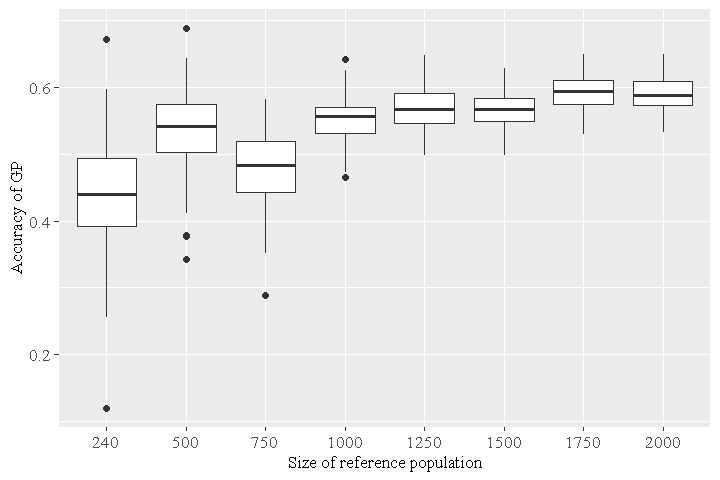

In [58]:
#Boxplot
library(ggplot2)
options(repr.plot.width=6, repr.plot.height=4)
plot<-data.frame(correlation=as.vector(t(all_acc)),
                 no_of_sample=as.factor(rep(n.sample,each = n.fold*repeats)))
p <- ggplot(plot, aes(x=no_of_sample, y=correlation))+
     geom_boxplot()+
     labs(x = "Size of reference population",y="Accuracy of GP")+
     theme(legend.position="none",
           axis.text.y=element_text(size=10),
           axis.text.x=element_text(size=10),
           text=element_text(size=10, 
           family="serif"))
p

In [57]:
# Save
png("2.1 Size of reference population.png", width=6, height=4, units="in", res=300)
p
dev.off()

png 
  2

In [46]:
#caculate the mean and se of accuracy of GP
cal_se<-function(acc){sd(acc)/sqrt(repeats-1)}
(sum<-data.frame(no_of_sample=n.sample,
                 acc_mean = apply(all_acc, 1, mean),
                 acc_se = apply(all_acc, 1, cal_se)))

no_of_sample,acc_mean,acc_se
240,0.4388824,0.030182497
500,0.5348484,0.022595243
750,0.4809595,0.021344959
1000,0.5497540,0.012919789
1250,0.5697551,0.011575666
1500,0.5655269,0.009653200
1750,0.5927709,0.008615323
2000,0.5873600,0.008948373


In [47]:
#save to xlsx file
library("xlsx")
write.xlsx(sum, "2_1.xlsx") 